# Introduction to vector databases

In this exercise you will learn how vector databases are used to store text. 

Text is converted to vectors through the use of an `embedding model`. An embedding model is a large language model that is designed to create vectors out of chunks of text. It is these vectors that will be stored in the database.

For the lab we will be using Milvus for our vector database.

### Step 1: Setup Environment

Install the required Python packages listed in `requirements.txt` to ensure all dependencies for the lab are available.

In [1]:
# Step 1: Install necessary libraries (run in a cell if needed)
!pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Step 2: Import Required Libraries

The following code block imports all necessary Python libraries and packages that will be used throughout this lab, including Milvus client, embedding model, and analysis tools.

In [2]:
# Milvus client for vector database operations
from pymilvus import connections, utility, Collection, CollectionSchema, FieldSchema, DataType
# SentenceTransformer for generating text embeddings
from sentence_transformers import SentenceTransformer
# Cosine similarity metric for embedding comparison
from sklearn.metrics.pairwise import cosine_similarity
# NumPy for numerical computations
import numpy as np
# Matplotlib for visualization
import matplotlib.pyplot as plt
# PCA for dimensionality reduction
from sklearn.decomposition import PCA

/opt/app-root/lib64/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Create the vector database

### Step 3: Create the Vector Database

In this step, we will connect to Milvus, define a collection schema, and create a new collection to store our text embeddings. The schema includes an integer ID and a float vector field for the embeddings.



In [3]:
# Define the Milvus collection name that will store our embeddings
collection_name = "vectordb_collection"  # Unique identifier for vector store

# Establish connection to Milvus vector database service
connections.connect(
    uri="http://milvus-service.milvus.svc.cluster.local:19530",  # Milvus server endpoint
    alias="default"  # Alias to reference this connection in later operations
)

In [4]:
# Remove any existing collection with the same name to start fresh
if utility.has_collection(collection_name):
    utility.drop_collection(collection_name)

# Display current collections to verify deletion
print(f"Collection list after cleanup: {utility.list_collections()}")

Collection list after cleanup: ['animal_test', 'my_rag_collection']


In [5]:
# Databases need a schema. In this lab the schema will consist 
# of an identifier and a vector that contains the embedding of a text string.

# Define the primary key field for unique record identification
id_field = FieldSchema(
    name="id",
    dtype=DataType.INT64,
    is_primary=True,
    auto_id=False
)

# Specify embedding model and its output dimension
embedding_model = "all-MiniLM-L6-v2"  # Example Hugging Face model
embedding_dim = 384  # Embedding vector size as per the model

# Define the vector field to hold embedding values
embedding_field = FieldSchema(
    name="embedding",
    dtype=DataType.FLOAT_VECTOR,
    dim=embedding_dim
)

# Assemble collection schema combining ID and embedding fields
schema = CollectionSchema(
    fields=[id_field, embedding_field],
    description="Milvus shakeout test",
    enable_dynamic_field=False
)

In [6]:
# Instantiate the Milvus collection using the defined schema and configuration
collection = Collection(
    name=collection_name, 
    schema=schema, 
    using='default', 
    shards_num=2,
    consistency_level="Strong"
)

# Display the collection schema that was just created
print(f"Collection: {collection.schema}\n")

# List all collections in Milvus to confirm creation
print(f"Collection list: {utility.list_collections()}")

Collection: {'auto_id': False, 'description': 'Milvus shakeout test', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': False}, {'name': 'embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 384}}], 'enable_dynamic_field': False}

Collection list: ['my_rag_collection', 'vectordb_collection', 'animal_test']


## Create test data for the vector database

### Step 4: Generate Embeddings and Create Test Data

In this step, we use a Hugging Face embedding model to convert text terms into high-dimensional vectors that will be stored in the database.

In [7]:
# Generate embeddings using a simple embedding model from Hugging Face 
model = SentenceTransformer(embedding_model)

# We will put three words into the database and hope to see how the vector database uses the 
# embedding model to store these in a way where we can find the most similar words (cat and dog)
terms = ["dog", "cat", "pumpkin"]
embeddings = model.encode(terms)

# Display the first 5 rows of embedding data. Observe that these are now vectors.
for term, vector in zip(terms, embeddings):
    print(f"Embedding for '{term}' (first 5 values):\n{vector[:5]}\n")

Embedding for 'dog' (first 5 values):
[-0.053147    0.0141944   0.00714573  0.06860867 -0.07848035]

Embedding for 'cat' (first 5 values):
[ 0.03733037  0.05116179 -0.00030609  0.06020984 -0.11749443]

Embedding for 'pumpkin' (first 5 values):
[ 0.00623484  0.02070913 -0.05396153  0.05416825 -0.01124374]



In [8]:
# Create a "list of dictionaries" data structure that matches the schema we defined for the vector database. E.g.
# [
#    {"id": 0, "embedding": [0.1, 0.2, ...]},
#    {"id": 1, "embedding": [0.3, 0.4, ...]},
#    {"id": 2, "embedding": [0.6, 0.2, ...]}
#]
data = [
    {"id": i, "embedding": vec}
    for i, vec in enumerate(embeddings.tolist())
]

In [9]:
# Insert the vectors into the collection
collection.insert(data=data)

(insert count: 3, delete count: 0, upsert count: 0, timestamp: 459220438027075588, success count: 3, err count: 0

In [10]:
# Create index on the vector field
collection.create_index(
    field_name="embedding",
    index_params={
        "metric_type": "COSINE",
        "index_type": "IVF_FLAT",
        "params": {"nlist": 128}
    },
    index_name="idx"
)


collection.flush()
collection.load()

## Test data retrieval

### Step 5: Test Data Retrieval

In this step, we define a function to search the collection using an embedding and retrieve the most similar items based on cosine similarity.

In [11]:
# Prove we can retrieve data from the database
def search(term):
    vector = model.encode([term])
    results = collection.search(vector, "embedding", param={"metric_type": "COSINE"}, limit=3)
    return results

results_dog = search("dog")
print(f"Results: {results_dog}")

Results: data: ["['id: 0, distance: 0.9999999403953552, entity: {}', 'id: 1, distance: 0.6606375575065613, entity: {}', 'id: 2, distance: 0.3701188564300537, entity: {}']"]


In [12]:
# Perform a cosine similarity search to find how similar dog (embeddings[0]) is to cat and pumpkin (embeddings[1:]).
cos_sim = cosine_similarity([embeddings[0]], embeddings[1:])

print("Similarity (dog vs cat):", cos_sim[0][0])
print("Similarity (dog vs pumpkin):", cos_sim[0][1])

Similarity (dog vs cat): 0.6606376
Similarity (dog vs pumpkin): 0.37011895


### Step 6: Visualize Embeddings

Here we reduce the high-dimensional embeddings to 2D using PCA and plot the terms to observe their relative positions and relationships.

Observe that dog and cat are more similar than dog and pumpkin

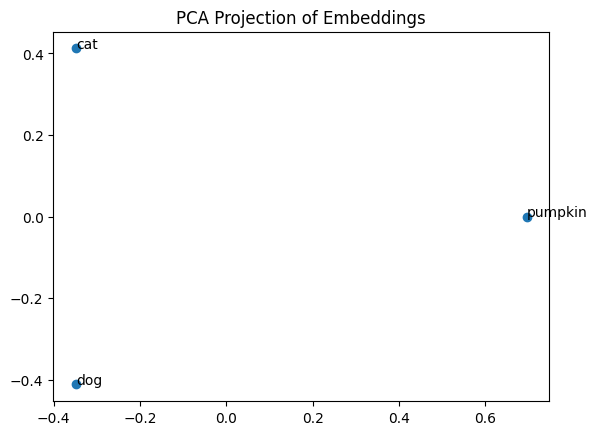

In [13]:
# Visualise the result
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, term in enumerate(terms):
    plt.annotate(term, (reduced[i, 0], reduced[i, 1]))
plt.title("PCA Projection of Embeddings")
plt.show()

In [14]:
# Close the Milvus connection
collection.release()
utility.drop_collection(collection_name)